In [643]:
import pandas as pd
import scipy
import numpy as np
import nltk
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt
import matplotlib.cm as cm
#% matplotlib inline
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('words')
from nltk.corpus import stopwords
from gensim.models import KeyedVectors
stop_words = set(stopwords.words("english"))
from nltk.corpus import words
english_words=set(words.words())

[nltk_data] Downloading package punkt to /Users/Souvik/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/Souvik/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package words to /Users/Souvik/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [594]:
model = KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)

In [595]:
apps_description=pd.read_csv('appleStore_description.csv')

In [596]:
apps_description

,id,track_name,size_bytes,app_desc
0,281656475,PAC-MAN Premium,100788224,"SAVE 20%, now only $3.99 for a limited time!\n..."
1,281796108,Evernote - stay organized,158578688,Let Evernote change the way you organize your ...
2,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,Download the most popular free weather app pow...
3,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,The eBay app is the best way to find anything ...
4,282935706,Bible,92774400,On more than 250 million devices around the wo...
...,...,...,...,...
7192,1187617475,Kubik,126644224,Place the falling blocks correctly in order to...
7193,1187682390,VR Roller-Coaster,120760320,A thrilling virtual reality roller coaster exp...
7194,1187779532,Bret Michaels Emojis + Lyric Keyboard,111322112,"Rock star Bret Michaels, winner of Celebrity A..."
7195,1187838770,VR Roller Coaster World - Virtual Reality,97235968,VR Roller Coaster World is an app for Google C...


In [597]:
def calculate_vectors(row,model):
    sentences = nltk.sent_tokenize(row)    
    words=[]
    for sentence in sentences:
        words = words + nltk.word_tokenize(sentence)
    words = [word for word in words if not word in stop_words]    
    number_words_model=0
    vector_sum=[0.0]*300
    for i,word in enumerate(words):
        if word in model:
            vector_sum+=model[word]
            number_words_model+=1
    if number_words_model>0:         
        return vector_sum/number_words_model        
    else:
        return [0]

In [598]:
apps_description['average_vector']=apps_description['app_desc'].apply(lambda x: calculate_vectors(x,model))

In [600]:
apps_description_filtered=apps_description[apps_description['average_vector'].apply(lambda x: len(x)==300)]

In [601]:
keys = ['music','food','party','exercise','sports','weather','game','media']

embedding_clusters = []
word_clusters = []
for word in keys:
    embeddings = []
    words = []
    for similar_word in find_apps(word,5):
        words.append((' ').join(similar_word.split()[0:5]))
        embeddings.append(apps_description_filtered[apps_description_filtered['track_name']==similar_word]['average_vector'].to_numpy()[0])
    embedding_clusters.append(embeddings)
    word_clusters.append(words)

/Users/Souvik/Documents/anaconda/envs/mypython3/lib/python3.6/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


In [602]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=9, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

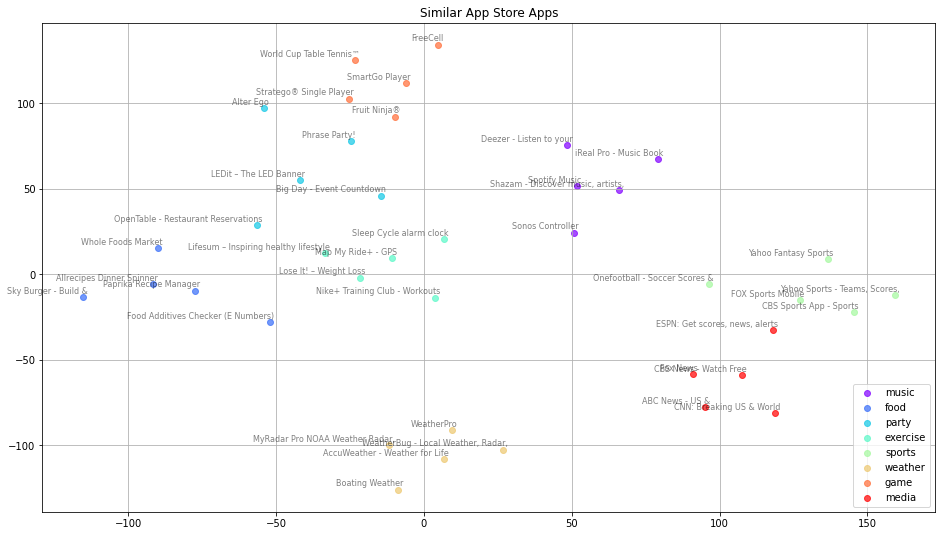

In [603]:
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('Similar App Store Apps', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

In [604]:
for i in apps_description.iterrows(): 
  index_app_map[i[1].id]=i[1].track_name

In [605]:
def find_apps(keyword,n):
    test_vector=calculate_vectors(keyword,model)
    index_distance_tuples=[]
    for i in apps_description.iterrows(): 
        index_distance_tuples.append((i[1].id,scipy.spatial.distance.cosine(i[1].average_vector,test_vector)))
    nearest_app_indices=sorted(index_distance_tuples, key=lambda x: x[1])[0:n]
    nearest_app_names= [index_app_map[x[0]] for x in nearest_app_indices ]
    return nearest_app_names    

In [606]:
find_apps('weather',10)

/Users/Souvik/Documents/anaconda/envs/mypython3/lib/python3.6/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


['AccuWeather - Weather for Life',
 'WeatherPro',
 'MyRadar Pro NOAA Weather Radar, Forecasts & Storms',
 'Boating Weather',
 'WeatherBug - Local Weather, Radar, Maps, Alerts',
 'Living Earth - Clock & Weather',
 'The Weather Channel: Forecast, Radar & Alerts',
 'MyRadar NOAA Weather Radar Forecast',
 'NOAA Hi-Def Radar Pro -  Storm Warnings, Hurricane Tracker & Weather Forecast',
 'Virtual Regatta Offshore']

In [548]:
find_apps('food',10)

/Users/Souvik/Documents/anaconda/envs/mypython3/lib/python3.6/site-packages/scipy/spatial/distance.py:720: RuntimeWarning: invalid value encountered in double_scalars
  dist = 1.0 - uv / np.sqrt(uu * vv)


['Food Additives Checker (E Numbers)',
 'Sky Burger - Build & Match Food Free',
 'Allrecipes Dinner Spinner',
 'Paprika Recipe Manager',
 'Whole Foods Market',
 'Alipay - Makes Life Easy',
 'OpenTable - Restaurant Reservations',
 'Yelp - Nearby Restaurants, Shopping & Services',
 'Starbucks',
 "Sam's Club: Wholesale Shopping & Bulk Buy Deals"]

In [337]:
find_apps('sports',10)

['CBS Sports App - Sports Scores, News, Stats, Watch',
 'Yahoo Sports - Teams, Scores, News & Highlights',
 'FOX Sports Mobile',
 'Onefootball - Soccer Scores & Live News',
 'Yahoo Fantasy Sports',
 'Top Eleven 2017 - Be a Soccer Manager',
 'NFL',
 'ESPN: Get scores, news, alerts & watch live sports',
 'ABC News - US & World News + Live Video',
 "Ricky Carmichael's Motocross Matchup Pro"]

In [338]:
find_apps('exercise',10)

['Lose It! – Weight Loss Program and Calorie Counter',
 'Nike+ Training Club - Workouts & Fitness Plans',
 'Lifesum – Inspiring healthy lifestyle app',
 'Map My Ride+ - GPS Cycling & Route Tracker',
 'Sleep Cycle alarm clock',
 'Period Tracker Deluxe',
 'Map My Run+ - GPS Running & Workout Tracker',
 'Period Tracker Lite',
 'Weight Watchers',
 'SmartGo Player']

In [339]:
find_apps('party',10)

['Big Day - Event Countdown',
 'Phrase Party!',
 'LEDit – The LED Banner App',
 'Alter Ego',
 'OpenTable - Restaurant Reservations',
 'Wedding Dash Deluxe',
 'Alipay - Makes Life Easy',
 'Election 2016 Map',
 'Peekaboo Barn',
 'Virtual Families']

In [361]:
find_apps('music',10)

['iReal Pro - Music Book & Play Along',
 'Sonos Controller',
 'Deezer - Listen to your Favorite Music & Playlists',
 'Shazam - Discover music, artists, videos & lyrics',
 'Spotify Music',
 'Cleartune - Chromatic Tuner',
 'I Am T-Pain 2.0',
 'iHeartRadio – Free Music & Radio Stations',
 'Pandora - Music & Radio',
 'Peekaboo Barn']

In [368]:
find_apps('game',10)

['World Cup Table Tennis™',
 'SmartGo Player',
 'Stratego® Single Player',
 'FreeCell',
 'Fruit Ninja®',
 'Dungeon Raid',
 'Top Eleven 2017 - Be a Soccer Manager',
 'Beer Pong Game',
 'Neuroshima Hex',
 '10 Pin Shuffle Pro Bowling']

In [378]:
find_apps('media',10)

['CNN: Breaking US & World News, Live Video',
 'CBS News - Watch Free Live Breaking News',
 'ABC News - US & World News + Live Video',
 'Fox News',
 'ESPN: Get scores, news, alerts & watch live sports',
 'Ameba',
 'HuffPost - News, Politics & Entertainment',
 'Twitter',
 'NBC News',
 'Sky News']

In [549]:
find_apps('mystery game',10)

['Canabalt',
 '▻Solitaire',
 'The Secret of Grisly Manor',
 'Neuroshima Hex',
 'Dungeon Raid',
 'LEGO Harry Potter: Years 1-4',
 'FreeCell',
 'Shoot The Zombirds',
 "Reiner Knizia's Ra",
 'Super Stickman Golf']

In [577]:
find_apps('social media',10)

['Twitter',
 'CBS News - Watch Free Live Breaking News',
 'CNN: Breaking US & World News, Live Video',
 'ABC News - US & World News + Live Video',
 'HuffPost - News, Politics & Entertainment',
 'NBC News',
 'ESPN: Get scores, news, alerts & watch live sports',
 'Sky News',
 'Parking Mania',
 'LinkedIn']

In [584]:
find_apps('watch tv',10)

['CNN: Breaking US & World News, Live Video',
 'ESPN: Get scores, news, alerts & watch live sports',
 'Twitter',
 'MSNBC',
 'Sunday Ticket',
 'NFL Sunday Ticket',
 'ABC News - US & World News + Live Video',
 'CBS News - Watch Free Live Breaking News',
 'The Masters Tournament',
 'DIRECTV']

In [570]:
find_apps('pay bills',10)

['Alipay - Makes Life Easy',
 'Mint: Personal Finance, Budget, Bills & Money',
 'PayPal - Send and request money safely',
 'iLoan Calc (Loan calculator)',
 'HomeBudget with Sync',
 'Dropbox',
 'Starbucks',
 'Bank of America - Mobile Banking',
 'Chase Mobile℠',
 'Zillow Real Estate - Homes for Sale & for Rent']

In [556]:
find_apps('watch football',10)

['CBS Sports App - Sports Scores, News, Stats, Watch',
 'Sunday Ticket',
 'NFL Sunday Ticket',
 'Yahoo Sports - Teams, Scores, News & Highlights',
 'FOX Sports Mobile',
 'Top Eleven 2017 - Be a Soccer Manager',
 'PGA Championship 2016 – Baltusrol Golf Club',
 'ESPN: Get scores, news, alerts & watch live sports',
 'NFL',
 'The Championships, Wimbledon 2016 - Tennis Grand Slam']

In [586]:
find_apps('wedding party',10)

['Wedding Dash Deluxe',
 'Big Day - Event Countdown',
 'Alter Ego',
 'OpenTable - Restaurant Reservations',
 'LEDit – The LED Banner App',
 'Shutterfly: Prints, Photo Books, Cards Made Easy',
 'Match™ - #1 Dating App.',
 'Alipay - Makes Life Easy',
 'The Championships, Wimbledon 2016 - Tennis Grand Slam',
 'Grindr - Gay and same sex guys chat, meet and date']

In [589]:
find_apps('tempo',10)

['iReal Pro - Music Book & Play Along',
 'Tempo - Metronome with Setlists',
 'Canabalt',
 'SmartGo Player',
 'Cleartune - Chromatic Tuner',
 'World Cup Table Tennis™',
 'Lane Splitter',
 'Chess Pro with Coach - Learn,Play & Online Friends',
 'I Dig It',
 'Neuroshima Hex']

In [616]:
def check_english(row,model):
    sentences = nltk.sent_tokenize(row)    
    words=[]
    for sentence in sentences:
        words = words + nltk.word_tokenize(sentence)
    words = [word for word in words if not word in stop_words]    
    count_english_words=0
    for word in words:
        if word in english_words:
            count_english_words+=1
    if count_english_words>5:
        return 1
    else:
        return 0

In [617]:
apps_description_filtered['check_english']=apps_description_filtered['app_desc'].apply(lambda x: check_english(x,model))

/Users/Souvik/Documents/anaconda/envs/mypython3/lib/python3.6/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [618]:
apps_description_filtered

,id,track_name,size_bytes,app_desc,average_vector,cluster,check_english
0,281656475,PAC-MAN Premium,100788224,"SAVE 20%, now only $3.99 for a limited time!\n...","[0.053137908747166764, 0.017843693862726658, 0...",19,1
1,281796108,Evernote - stay organized,158578688,Let Evernote change the way you organize your ...,"[0.030817609314524798, -0.003614385193641033, ...",8,1
2,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,Download the most popular free weather app pow...,"[0.014187305004565746, -0.024998190083028952, ...",12,1
3,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,The eBay app is the best way to find anything ...,"[0.03209552806088013, 0.05188517745576204, -0....",12,1
4,282935706,Bible,92774400,On more than 250 million devices around the wo...,"[0.06322208990497649, -0.033529873551993536, -...",8,1
...,...,...,...,...,...,...,...
7192,1187617475,Kubik,126644224,Place the falling blocks correctly in order to...,"[-0.005232186153017241, 0.011828192349137932, ...",0,1
7193,1187682390,VR Roller-Coaster,120760320,A thrilling virtual reality roller coaster exp...,"[0.015625, 0.0052947998046875, -0.024238586425...",19,1
7194,1187779532,Bret Michaels Emojis + Lyric Keyboard,111322112,"Rock star Bret Michaels, winner of Celebrity A...","[0.05234375, -0.0371685791015625, -0.009476318...",13,1
7195,1187838770,VR Roller Coaster World - Virtual Reality,97235968,VR Roller Coaster World is an app for Google C...,"[0.025122764783027846, -0.045728243314302884, ...",19,1


In [619]:
apps_description_filtered_english=apps_description_filtered[apps_description_filtered['check_english']==1]

In [620]:
apps_description_filtered_english

,id,track_name,size_bytes,app_desc,average_vector,cluster,check_english
0,281656475,PAC-MAN Premium,100788224,"SAVE 20%, now only $3.99 for a limited time!\n...","[0.053137908747166764, 0.017843693862726658, 0...",19,1
1,281796108,Evernote - stay organized,158578688,Let Evernote change the way you organize your ...,"[0.030817609314524798, -0.003614385193641033, ...",8,1
2,281940292,"WeatherBug - Local Weather, Radar, Maps, Alerts",100524032,Download the most popular free weather app pow...,"[0.014187305004565746, -0.024998190083028952, ...",12,1
3,282614216,"eBay: Best App to Buy, Sell, Save! Online Shop...",128512000,The eBay app is the best way to find anything ...,"[0.03209552806088013, 0.05188517745576204, -0....",12,1
4,282935706,Bible,92774400,On more than 250 million devices around the wo...,"[0.06322208990497649, -0.033529873551993536, -...",8,1
...,...,...,...,...,...,...,...
7192,1187617475,Kubik,126644224,Place the falling blocks correctly in order to...,"[-0.005232186153017241, 0.011828192349137932, ...",0,1
7193,1187682390,VR Roller-Coaster,120760320,A thrilling virtual reality roller coaster exp...,"[0.015625, 0.0052947998046875, -0.024238586425...",19,1
7194,1187779532,Bret Michaels Emojis + Lyric Keyboard,111322112,"Rock star Bret Michaels, winner of Celebrity A...","[0.05234375, -0.0371685791015625, -0.009476318...",13,1
7195,1187838770,VR Roller Coaster World - Virtual Reality,97235968,VR Roller Coaster World is an app for Google C...,"[0.025122764783027846, -0.045728243314302884, ...",19,1


In [621]:
app_vectors=[]
for i in apps_description_filtered_english.iterrows():
    app_vectors.append(i[1].average_vector)
app_vectors=np.array(app_vectors)    

In [622]:
km = KMeans(n_clusters=20, random_state=0).fit(app_vectors)

In [625]:
clusters = km.labels_.tolist()
apps_description_filtered_english["cluster"] = clusters


/Users/Souvik/Documents/anaconda/envs/mypython3/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [626]:
num_of_clusters=20
embedding_clusters = [0]*num_of_clusters
word_clusters = [0]*num_of_clusters
for i in apps_description_filtered_english.iterrows():
    cluster=i[1].cluster
    if word_clusters[cluster]==0:
        word_clusters[cluster]=[]
        embedding_clusters[cluster]=[]
        embedding_clusters[cluster].append(i[1].average_vector)
        word_clusters[cluster].append(' '.join(i[1].track_name.split()[0:3]))
    else:
        if len(word_clusters[cluster])<25:
            word_clusters[cluster].append(' '.join(i[1].track_name.split()[0:3]))
            embedding_clusters[cluster].append(i[1].average_vector)

In [630]:
num_of_clusters=20
keys = ['Cluster'+ str(i) for i in range(num_of_clusters)]
apps_to_plot=25
embedding_clusters = [0]*num_of_clusters
word_clusters = [0]*num_of_clusters
for i in apps_description_filtered_english.iterrows():
    cluster=i[1].cluster
    if embedding_clusters[cluster]==0:
        word_clusters[cluster]=[]
        embedding_clusters[cluster]=[]
        embedding_clusters[cluster].append(i[1].average_vector)
        word_clusters[cluster].append(cluster)
    else:
        if len(word_clusters[cluster])<apps_to_plot:
            word_clusters[cluster].append(cluster)
            embedding_clusters[cluster].append(i[1].average_vector)

'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with 'x' & 'y'.  Please use a 2-D array with a single row if you really want to specify the same RGB or RGBA value for all points.
'c' argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches

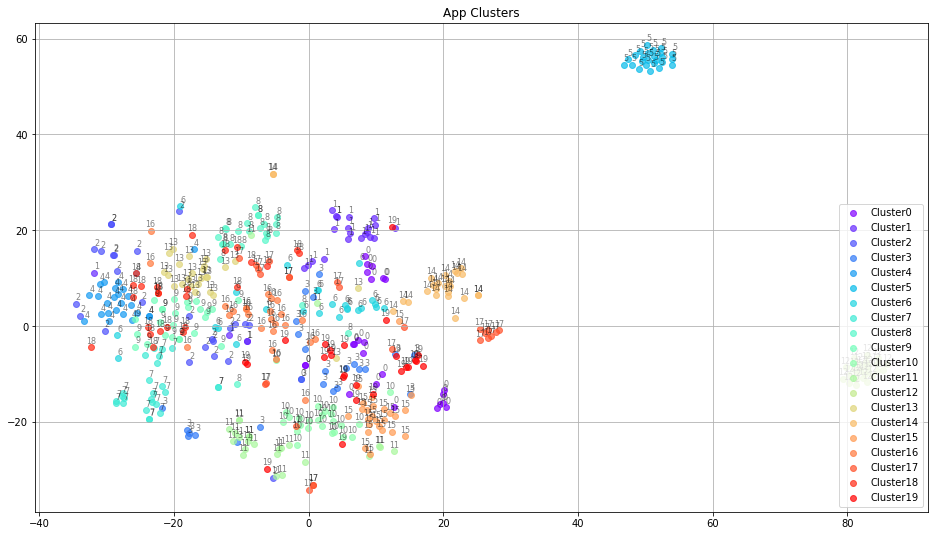

In [631]:
embedding_clusters = np.array(embedding_clusters)
n, m, k = embedding_clusters.shape
tsne_model_en_2d = TSNE(perplexity=20, n_components=2, init='pca', n_iter=3500, random_state=32)
embeddings_en_2d = np.array(tsne_model_en_2d.fit_transform(embedding_clusters.reshape(n * m, k))).reshape(n, m, 2)
def tsne_plot_similar_words(title, labels, embedding_clusters, word_clusters, a, filename=None):
    plt.figure(figsize=(16, 9))
    colors = cm.rainbow(np.linspace(0, 1, len(labels)))
    for label, embeddings, words, color in zip(labels, embedding_clusters, word_clusters, colors):
        x = embeddings[:, 0]
        y = embeddings[:, 1]
        plt.scatter(x, y, c=color, alpha=a, label=label)
        for i, word in enumerate(words):
            plt.annotate(word, alpha=0.5, xy=(x[i], y[i]), xytext=(5, 2),
                         textcoords='offset points', ha='right', va='bottom', size=8)
    plt.legend(loc=4)
    plt.title(title)
    plt.grid(True)
    if filename:
        plt.savefig(filename, format='png', dpi=150, bbox_inches='tight')
    plt.show()


tsne_plot_similar_words('App Clusters', keys, embeddings_en_2d, word_clusters, 0.7,
                        'similar_words.png')

In [632]:
num_of_clusters=20
embedding_clusters = [0]*num_of_clusters
word_clusters = [0]*num_of_clusters
for i in apps_description_filtered_english.iterrows():
    cluster=i[1].cluster
    if word_clusters[cluster]==0:
        word_clusters[cluster]=[]
        embedding_clusters[cluster]=[]
        embedding_clusters[cluster].append(i[1].average_vector)
        word_clusters[cluster].append(' '.join(i[1].track_name.split()[0:3]))
    else:
        if len(word_clusters[cluster])<25:
            word_clusters[cluster].append(' '.join(i[1].track_name.split()[0:3]))
            embedding_clusters[cluster].append(i[1].average_vector)

In [633]:
word_clusters[5][5:15]

["franceinfo - l'actualité",
 'AlloCiné : Cinéma',
 '6play, TV en',
 'Résultats Foot en',
 'Météo-France',
 'Ma Banque',
 'La Banque Postale',
 'Programme TV Télé',
 'Mon compte pour',
 'Impots.gouv']

In [634]:
word_clusters[12][0:10]

['radio.de - Der',
 'n-tv Nachrichten',
 'TV SPIELFILM -',
 'Jourist Weltübersetzer',
 'Der Feueralarm',
 'Tagesschau',
 'Verbrechen - echte',
 'Chefkoch - Rezepte,',
 'FOCUS Online -',
 'Oje, ich wachse!']

In [635]:
word_clusters[14][5:15]

['Google Translate',
 'Lieferando.de',
 'AliExpress Shopping App',
 'SayHi Translate',
 'ConjuVerb - Spanish',
 'Think in Japanese',
 'Translator !!',
 'iTranslate Voice -',
 'Voice Translate Pro',
 'HelloTalk Language Exchange']

In [636]:
word_clusters[11][0:10]

['Pandora - Music',
 'Shazam - Discover',
 'Cleartune - Chromatic',
 'White Noise',
 'Deezer - Listen',
 'Sonos Controller',
 'iReal Pro -',
 'Rowmote: Remote Control',
 'Tempo - Metronome',
 'Brain Wave ™']

In [637]:
word_clusters[8]

['SCRABBLE Premium',
 'Nike+ Training Club',
 'Peggle Classic',
 'TextNow - Unlimited',
 'The Sims 3',
 'Cartoon Wars',
 'BATTLE BEARS: Zombies!',
 'Sudoku⁺',
 'Victoria’s Secret –',
 'MONOPOLY Game',
 'Rat On A',
 'Grand Theft Auto:',
 'The Sims 3',
 'Roadside America',
 'Plants vs. Zombies',
 'Parents Calling Easter',
 'Plants vs. Zombies',
 'SCRABBLE Premium for',
 'BATTLE BEARS -1',
 'Onefootball - Soccer',
 'Decide Now!',
 'Reckless Racing HD',
 'Ugly Meter™',
 'The Sims 3',
 'BUBBLE BOBBLE DOUBLE']

In [638]:
word_clusters[13][0:10]

['Line Rider iRide™',
 '2XL Supercross',
 'AirCoaster - Roller',
 'Drift Mania Championship',
 'Autohome-Find new＆Used Cars',
 'Bloons Super Monkey',
 'Virtual Regatta Offshore',
 '2XL Supercross HD',
 'Lane Splitter',
 'Mountain Biker']

In [639]:
word_clusters[1][0:10]

['Allrecipes Dinner Spinner',
 'Sky Burger -',
 'Cake Doodle',
 'Paprika Recipe Manager',
 "Annabel Karmel's Baby",
 "Domino's Pizza USA",
 'Green Kitchen –',
 'Toca Kitchen',
 'Nom Nom Paleo',
 'Cooking Academy (Full)']

In [640]:
word_clusters[7][1:15]

['Blackjack by MobilityWare',
 'FOX Sports Mobile',
 'Phase 10 Pro',
 'Beer Pong Game',
 'CBS Sports App',
 'The Masters Tournament',
 'World Cup Table',
 '2016 U.S. Open',
 'The Championships, Wimbledon',
 'Fantasy Football Manager',
 'PGA Championship 2016',
 'NFL Sunday Ticket',
 '2016 US Open',
 'Yahoo Fantasy Sports']

In [641]:
word_clusters[10][1:15]

['Color Splash',
 'iSwap Faces',
 'Shutterfly: Prints, Photo',
 'Camera+',
 'Camera Plus: For',
 'CatPaint',
 'Hipstamatic',
 'Timetracks - Slit-Scan',
 'Dr. Seuss Camera',
 'Slow Shutter Cam',
 'AgingBooth',
 'iWatermark - Watermark',
 'Drawing Pad',
 'Graphic - illustration']

In [642]:
word_clusters[0][1:15]

['PayPal - Send',
 'Bank of America',
 'TripAdvisor Hotels Flights',
 'Yelp - Nearby',
 'Lifesum – Inspiring',
 'LinkedIn',
 'Deliveries: a package',
 'HotSchedules',
 'OpenTable - Restaurant',
 'Lose It! –',
 'Target',
 'Amazon App: shop,',
 'Chase Mobile℠',
 'Mint: Personal Finance,']